<a href="https://colab.research.google.com/github/dimakpa/ML_Projects/blob/main/NYEnergy_regression2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Оценка и сравнение моделей машинного обучения

Импортируем для начала библиотеки, которые пригодятся в дальнейшем

In [3]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import  MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

Скачаем наши заготовки с гугл диска

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Read in data into dataframes
train_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NYEnergyRegressionData/training_features.csv')
test_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NYEnergyRegressionData/testing_features.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NYEnergyRegressionData/training_labels.csv')
test_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NYEnergyRegressionData/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


In [4]:
train_features.head(7)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

Проверили снова данные, которых не хватает

In [6]:
missing_values_table(train_features)

Your selected dataframe has 64 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
log_Water Intensity (All Water Sources) (gal/ft²),2155,32.5
Water Intensity (All Water Sources) (gal/ft²),2120,32.0
Latitude,1252,18.9
Longitude,1252,18.9
Community Board,1252,18.9
Census Tract,1252,18.9
Weather Normalized Site Natural Gas Intensity (therms/ft²),973,14.7
log_Direct GHG Emissions (Metric Tons CO2e),428,6.5
Weather Normalized Site Electricity Intensity (kWh/ft²),326,4.9
DOF Gross Floor Area,32,0.5


Посмотрим целевую переменную, которую нужно исследовать Energy Star от колиества построек

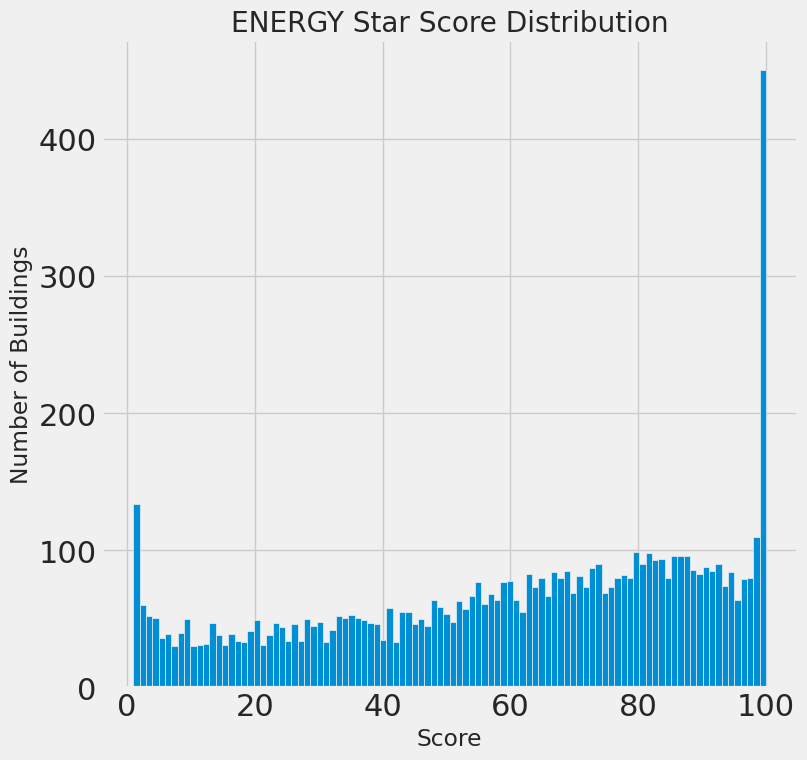

In [7]:
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings');
plt.title('ENERGY Star Score Distribution');

Стандартные модели машинного обучения не могут работать с пропущенными значениями, а это значит, что мы должны найти способ заполнить их или отбросить любые функции с пропущенными значениями. Поскольку в первой части мы уже удалили объекты с более чем 50% отсутствующими значениями, здесь мы сосредоточимся на заполнении этих отсутствующих значений, процесс, известный как вменение. Мы будем использовать относительно простой метод замены отсутствующих значений медианой столбца.

Создаем объект Imputer Scikit-learn, чтобы заполнить пропущенные значения медианой столбца.

In [8]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

Проверка на количество пропущенных значений

In [9]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


Нужно убедится, то все знаения конечны

In [10]:
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Масштабирование функций

Последний шаг, который нужно сделать, прежде чем мы сможем построить наши модели, — масштабировать функции. Это необходимо, потому что функции находятся в разных единицах, и мы хотим нормализовать функции, чтобы единицы не влияли на алгоритм. Линейная регрессия и случайный лес не требуют масштабирования признаков, но другие методы, такие как машины опорных векторов и k ближайших соседей, требуют его, поскольку они учитывают евклидово расстояние между наблюдениями. По этой причине рекомендуется масштабировать функции при сравнении нескольких алгоритмов.

Существует два способа масштабирования функций:

1. Для каждого значения вычтите среднее значение признака и разделите на стандартное отклонение признака. Это известно как стандартизация и приводит к тому, что каждая функция имеет среднее значение 0 и стандартное отклонение.

2. Для каждого значения вычтите минимальное значение функции и разделите на максимальное минус минимальное значение функции (диапазон). Это гарантирует, что все значения функции находятся в диапазоне от 0 до 1, и называется масштабированием до диапазона или нормализацией.

In [9]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [10]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Модели для оценивания

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

Сначала мы просто определим базовую производительность каждой модели, а затем мы выберем наиболее эффективную модель для дальнейшей оптимизации с помощью настройки гиперпараметров.Гиперпараметры по умолчанию заставят модель работать, но почти всегда их нужно корректировать с помощью поиска, чтобы найти лучшие настройки для нашей задачи!

Функция подсчета MAE

In [11]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

Функция, которая принимает модель, обуает модель и оценивает на тестовой выборке

In [12]:
def fit_and_evaluate(model):

    # Train the model
    model.fit(X, y)

    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)

    # Return the performance metric
    return model_mae

Модель линейной регрессии

In [15]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


Метод опорных векторов SVM

In [16]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


Метод рандомных лесов random forest

In [17]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 9.5231


Градиентный бустинг

In [18]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0116


Метод KNN (k-близжайших соседей)

In [19]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


Построим график моделей

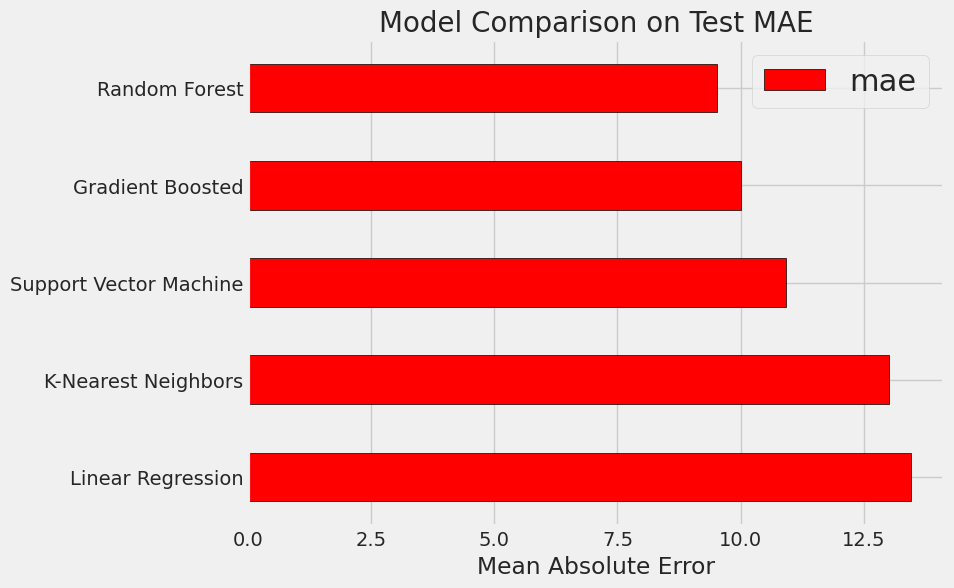

In [20]:
plt.style.use('fivethirtyeight')
figsize(8, 6)


model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae,
                                         gradient_boosted_mae, knn_mae]})


model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

Сравнение не сильно честное, потому что метод рандомного леса и градиентного бустинга не сильно зависит от начальных параметров, поэтому и результаты превосходят.

Мы будем использовать метод градинтного бустинга. "**Учитывая полученные здесь результаты, я сосредоточусь на использовании GradientBoostingRegressor. Это реализация Scikit-Learn Gradient Boosted Trees, которая выиграла множество соревнований Kaggle за последние несколько лет. Версия Scikit-Learn, как правило, медленнее, чем версия XGBoost, но здесь мы будем придерживаться Scikit-Learn, потому что синтаксис более знаком.**"

## Оптимизация модели

Сейчас мы будем заниматься поиском наиболее подходящих гиппараметров.

### Гипперпараметры

Параметры модели — это то, что модель узнает во время обучения, например веса в линейной регрессии.
А гипперпараметры - это настройки модели, которые задаются перед запуском, их как раз и настраивает специалист по моделям обуения. Настройка гиперпараметров модели контролирует баланс недостаточной и избыточной подгонки в модели.

Подбирать гипперпараметры важно, на каждый набор данных будет разный набор. Этот процесс долгий, поэтому его научились автоматизировать. Есть библиоткеа TPOT. Однако здесь мы будем подбирать вручную.

### Настройка гиперпараметров со случайным поиском и перекрестной проверкой

Случайный поиск относится к методу, в котором мы выбираем гиперпараметры для оценки: мы определяем диапазон параметров, а затем случайным образом выбираем комбинации для проверки
Перекрестная проверка — это метод, используемый для оценки производительности гиперпараметров.

Сначала создаем сетку гипперпараметров, которые могут быт использованы, затем выполняем итеративный процесс: случайным образом выбираем набор гиперпараметров из сетки, оцениваем гиперпараметры с помощью 4-кратной перекрестной проверки, а затем выбираем гиперпараметры с наилучшей производительностью.

In [21]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

Мы выбрали 6 различных гиперпараметров для настройки регрессора, повышающего градиент. Все они будут влиять на модель различными способами, которые трудно определить заранее, и единственный способ найти наилучшую комбинацию для конкретной проблемы — это проверить их. Потому что нет теории, которая могла бы сказать нам, какие из них будут работать лучше всего, нам просто нужно их оценить, как в эксперименте!

RandomizedSearchCV найдет за нас наилучший набор по данной сетке

*   оценщик: модель
*   param_distributions: распределение параметров, которое мы определили
*   cv : количество кратностей, используемых для k-кратной перекрестной проверки
*   n_iter: количество различных комбинаций, которые нужно попробовать
*   оценка: какую метрику использовать при оценке кандидатов
*   n_jobs: количество ядер для параллельного запуска (-1 будет использовать все доступные)
*   verbose: сколько информации отображать (1 отображает ограниченное количество)
*   return_train_score: возвращает оценку обучения для каждой складки перекрестной проверки.
*   random_state: исправляет используемый генератор случайных чисел, поэтому мы получаем одинаковые результаты при каждом запуске.

RandomizedSearchCV обучается как и все модели

In [22]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25,
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1,
                               return_train_score = True,
                               random_state=42)

In [23]:

# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
56 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_pa

RandomizedSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

Мы можем получить результаты рандомизированного поиска в фрейме данных и отсортировать значения по производительности.

In [24]:
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
3,28.510570,0.168819,0.021009,0.000495,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.872066,-8.904065,-9.317120,-9.075047,-9.042074,0.176555,1,-4.384343,-4.326121,-4.823009,-4.229809,-4.440820,0.227453
9,18.061206,0.537665,0.019563,0.006985,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.062882,-9.043722,-9.442664,-9.197954,-9.186805,0.159231,2,-6.955777,-7.088986,-6.913108,-6.949044,-6.976729,0.066811
10,134.986434,1.727136,0.107466,0.039885,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.193406,-9.254552,-9.565642,-9.464933,-9.369633,0.151493,3,-0.376942,-0.419973,-0.417745,-0.385657,-0.400079,0.019047
2,82.625786,1.396269,0.047763,0.001399,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.333559,-9.249347,-9.599790,-9.328477,-9.377793,0.132448,4,-0.167582,-0.180290,-0.155735,-0.139327,-0.160734,0.015104
21,8.983834,0.723275,0.029258,0.009339,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.365194,-9.286988,-9.751767,-9.409179,-9.453282,0.177800,5,-5.733003,-5.742441,-5.571781,-5.666476,-5.678425,0.068177
1,4.866566,0.105734,0.013598,0.004241,100,6,8,sqrt,10,huber,"{'n_estimators': 100, 'min_samples_split': 6, ...",-9.654491,-9.563284,-9.760660,-9.586534,-9.641242,0.076659,6,-5.115850,-5.197363,-5.223395,-5.231130,-5.191934,0.045674
8,120.017798,1.580058,0.197046,0.059702,1500,6,2,sqrt,10,huber,"{'n_estimators': 1500, 'min_samples_split': 6,...",-9.630076,-9.751876,-9.864687,-9.858023,-9.776165,0.095484,7,-0.170151,-0.165999,-0.176790,-0.162043,-0.168746,0.005458
20,47.847750,0.993560,0.069717,0.017914,500,6,1,sqrt,10,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.638482,-9.814223,-9.977284,-9.679523,-9.777378,0.132465,8,-0.337679,-0.349448,-0.353501,-0.314410,-0.338759,0.015212
18,158.783001,2.303685,0.120908,0.038355,500,6,1,auto,15,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-10.075558,-9.962943,-9.872734,-10.014923,-9.981539,0.074395,9,-0.002302,-0.002840,-0.002414,-0.002634,-0.002547,0.000207
6,262.286267,6.344749,0.292318,0.089704,1500,6,2,sqrt,15,huber,"{'n_estimators': 1500, 'min_samples_split': 6,...",-10.192961,-10.142236,-10.379401,-10.496965,-10.302891,0.142665,10,-0.045627,-0.050662,-0.049548,-0.040476,-0.046578,0.003989


In [25]:
random_cv.best_estimator_

GradientBoostingRegressor(loss='huber', max_depth=5, min_samples_leaf=8,
                          min_samples_split=6, n_estimators=500,
                          random_state=42)

Использование случайного поиска — хороший способ сузить круг возможных гиперпараметров. Изначально мы понятия не имели, какая комбинация будет работать лучше всего, но это, по крайней мере, сужает диапазон вариантов.

Мы могли бы использовать результаты случайного поиска для информирования поиска по сетке, создав сетку с гиперпараметрами, близкими к тем, которые лучше всего работали во время рандомизированного поиска. Однако вместо повторной оценки всех этих параметров я сосредоточусь на одном — количестве деревьев в лесу (n_estimators).

Здесь мы будем использовать поиск по сетке с сеткой, которая имеет только гиперпараметр n_estimators. Мы оценим ряд деревьев, а затем построим график обучения и тестирования, чтобы понять, что увеличение количества деревьев делает для нашей модели.

In [4]:
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss='huber',
                                  max_depth=5,
                                  min_samples_leaf=8,
                                  min_samples_split=6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4,
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [13]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(loss='huber', max_depth=5,
                                                 min_samples_leaf=8,
                                                 min_samples_split=6,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500, 550, 600, 650, 700, 750,
                                          800]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

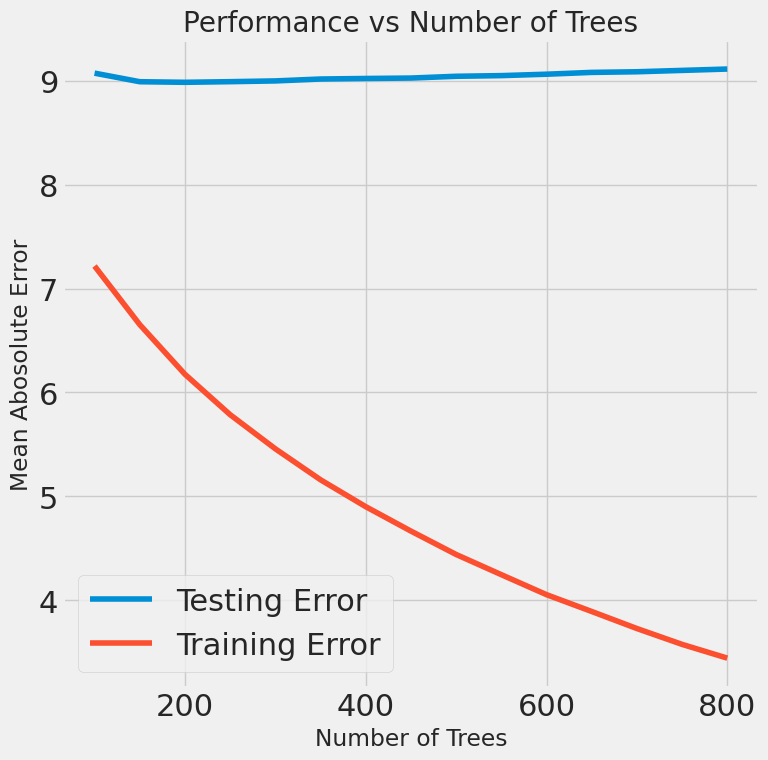

In [14]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [15]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
2,14.159671,0.643823,0.019367,0.007917,200,{'n_estimators': 200},-8.831720,-8.866122,-9.237441,-9.001288,-8.984143,0.159386,1,-6.265894,-6.159290,-6.217617,-6.056113,-6.174728,0.078196
1,10.913230,1.026643,0.012780,0.005424,150,{'n_estimators': 150},-8.822777,-8.865641,-9.241935,-9.028693,-8.989762,0.164618,2,-6.754404,-6.629251,-6.657734,-6.569515,-6.652726,0.066781
3,18.265004,0.239935,0.018082,0.005403,250,{'n_estimators': 250},-8.841388,-8.869993,-9.234708,-9.014632,-8.990180,0.155705,3,-5.884608,-5.762076,-5.833154,-5.663796,-5.785909,0.082845
4,20.523191,0.158401,0.016476,0.000532,300,{'n_estimators': 300},-8.851876,-8.871549,-9.243276,-9.023097,-8.997450,0.156629,4,-5.547992,-5.418679,-5.543205,-5.320502,-5.457595,0.094617
5,24.853436,1.263567,0.025492,0.013082,350,{'n_estimators': 350},-8.885733,-8.876912,-9.256010,-9.044168,-9.015706,0.153877,5,-5.220089,-5.111781,-5.333096,-4.973288,-5.159564,0.133003


Всегда будет разница между ошибкой обучения и ошибкой тестирования (ошибка обучения всегда ниже), но если есть значительная разница, мы хотим попытаться уменьшить переобучение, либо получив больше обучающих данных, либо уменьшив сложность модели, посредством настройки гиперпараметров или регуляризации.

Основываясь на результатах перекрестной проверки, лучшая модель использует 800 деревьев и достигает ошибки перекрестной проверки менее 9. Это указывает на то, что средняя оценка перекрестной проверки Energy Star Score находится в пределах 9 баллов от истинного ответа!

## Оценка окончательной модели на тестовом наборе

Используем лучшую модель из настройки гипперпараметров

In [16]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(loss='huber', max_depth=5, min_samples_leaf=8,
                          min_samples_split=6, n_estimators=200,
                          random_state=42)

In [17]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

3.09 s ± 494 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [18]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

12.3 s ± 1.47 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [19]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0119.
Final model performance on the test set:   MAE = 9.1620.


Окончательная модель превосходит базовую модель примерно на 10%, но за счет значительного увеличения времени работы (на моей машине она примерно в 12 раз медленнее). Машинное обучение часто является полем компромиссов: смещение против дисперсии, точность против интерпретируемости, точность против времени выполнения, и окончательное решение о том, какую модель использовать, зависит от ситуации. Здесь увеличение времени выполнения не является препятствием, потому что, хотя относительная разница велика, абсолютная величина времени обучения незначительна. В другой ситуации баланс может быть другим, поэтому нам нужно будет учитывать то, для чего мы оптимизируем, и ограничения, с которыми нам приходится работать.

Чтобы получить представление о прогнозах, мы можем построить график распределения истинных значений в тестовом наборе и прогнозируемых значений в тестовом наборе.

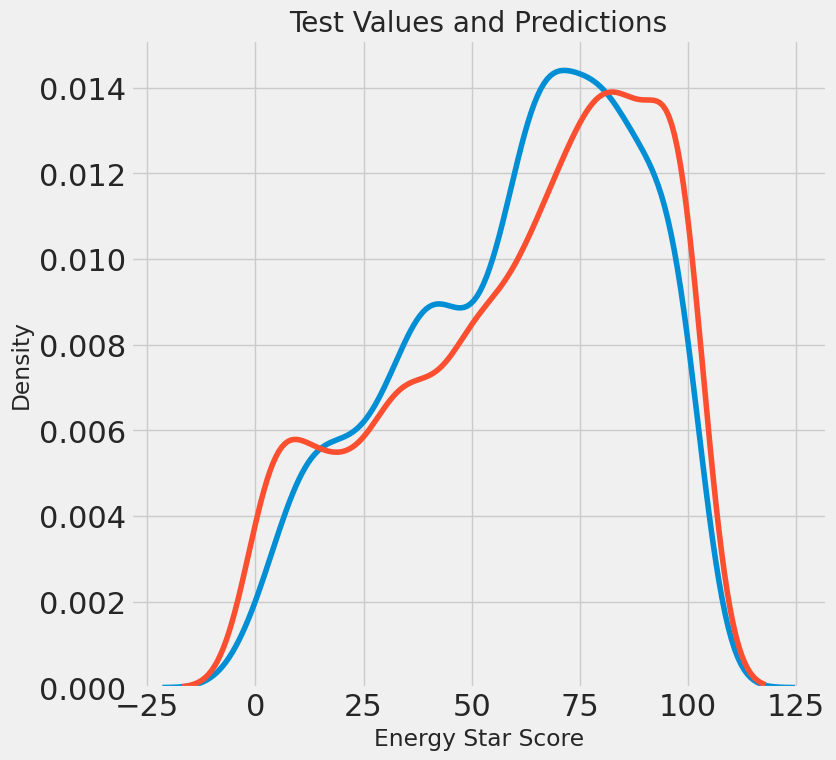

In [20]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

Распределение выглядит почти таким же.

Плотность предсказанных значений ближе к медиане тестовых значений, а не к фактическому пику в 100. Похоже, что модель может быть менее точной при предсказании экстремальных значений

Другой диагностический график представляет собой гистограмму остатков. В идеале мы надеемся, что остатки нормально распределены, а это означает, что модель ошибается одинаково в обоих направлениях (высоком и низком).

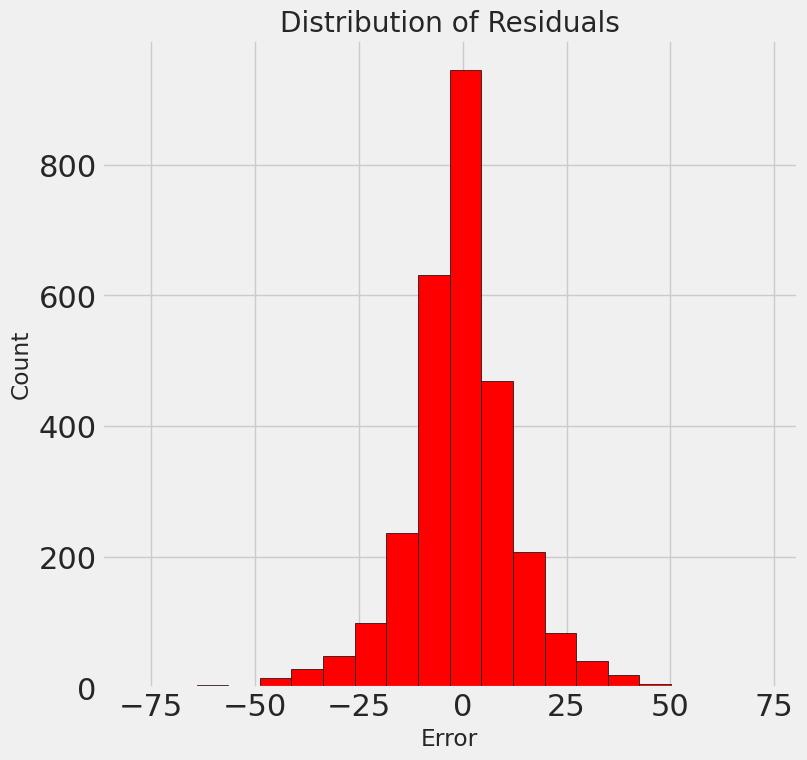

In [21]:
figsize = (6, 6)

# Calculate the residuals
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

Остатки близки к нормальному распределению с несколькими заметными выбросами в нижней части. Они указывают на ошибки, когда оценка модели была намного ниже истинного значения.

Следующий шаг в процессе машинного обучения имеет решающее значение: попытаться понять, как модель делает прогнозы. Достижение высокой точности — это здорово, но было бы также полезно, если бы мы могли понять, почему модель способна точно предсказывать, чтобы мы могли использовать эту информацию для лучшего понимания проблемы. Например, на какие функции опирается модель, чтобы вывести оценку Energy Star Score? Можно ли использовать эту модель для выбора признаков и реализовать более простую модель, которая более интерпретируема?